#To detect danger for blind people
###Our project will be divided into three parts: object detection, measurement of the object distances, and giving response to the user.
###We take some photos for imitating the real situation to test whether object detection can be used in the project.

#Object Detection

#####It is used to detect the object whether it is a perosn or not.
#####Copyright 2018 The TensorFlow Hub Authors.
#####View on the tensorflow hub: [object detection](https://www.tensorflow.org/hub/tutorials/object_detection)

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import and function the tensorflow hub

In [ ]:
#for running the tensorflow hub module
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Tensorflow version:',tf.__version__)

import tensorflow_hub as hub

#for downloading image
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

#for drawing on to the image
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time


Num GPUs Available:  0
Tensorflow version: 2.7.0


### Download images for visualization

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Take our photo as an example. The image is reshaped so that it will be different.

Image downloaded to /tmp/tmpcu2vu8ct.jpg.


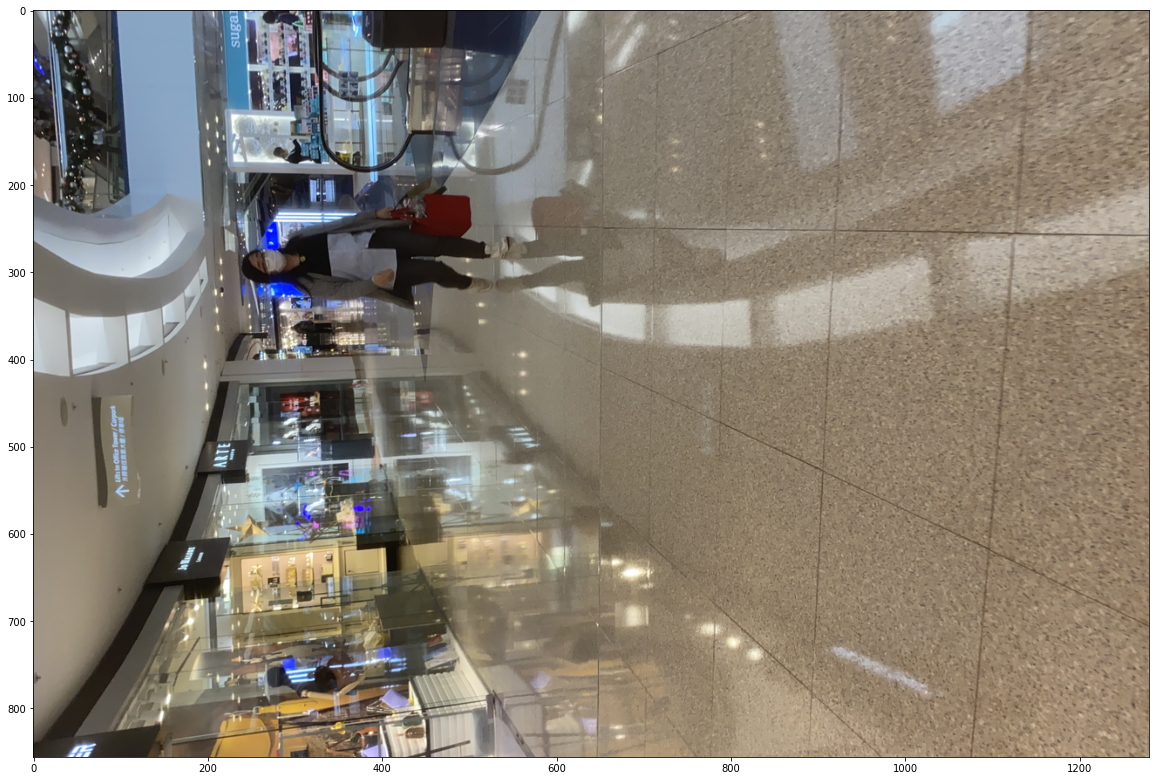

In [ ]:
image_url = "https://storage.googleapis.com/human_photo5/IMG_7914.JPG" 
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  49.97134852409363


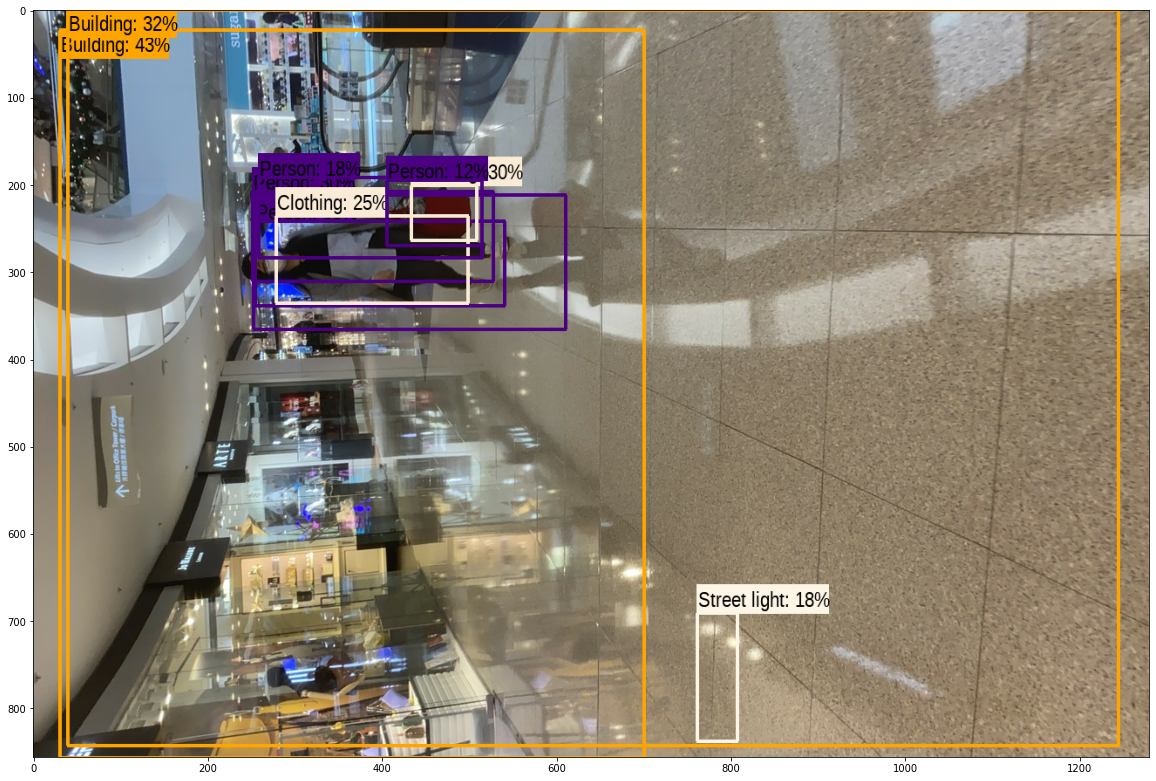

In [ ]:
run_detector(detector, downloaded_image_path)

It shows that the module can define a person in the image.
 (The purple rectangle)

It is better that if the photo can clearly show the human face.

We try to test with more photo to observe the accuracy.

In [ ]:
image_urls = [
  "https://storage.googleapis.com/human_photo5/IMG_7914.JPG",
  
  "https://storage.googleapis.com/human_photo6/IMG_20211219_120933.jpg",

  "https://storage.googleapis.com/human_photo4/IMG_20211219_121044.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpp9bzenmi.jpg.
Found 100 objects.
Inference time:  24.67235255241394
Inference time: 25.713171005249023


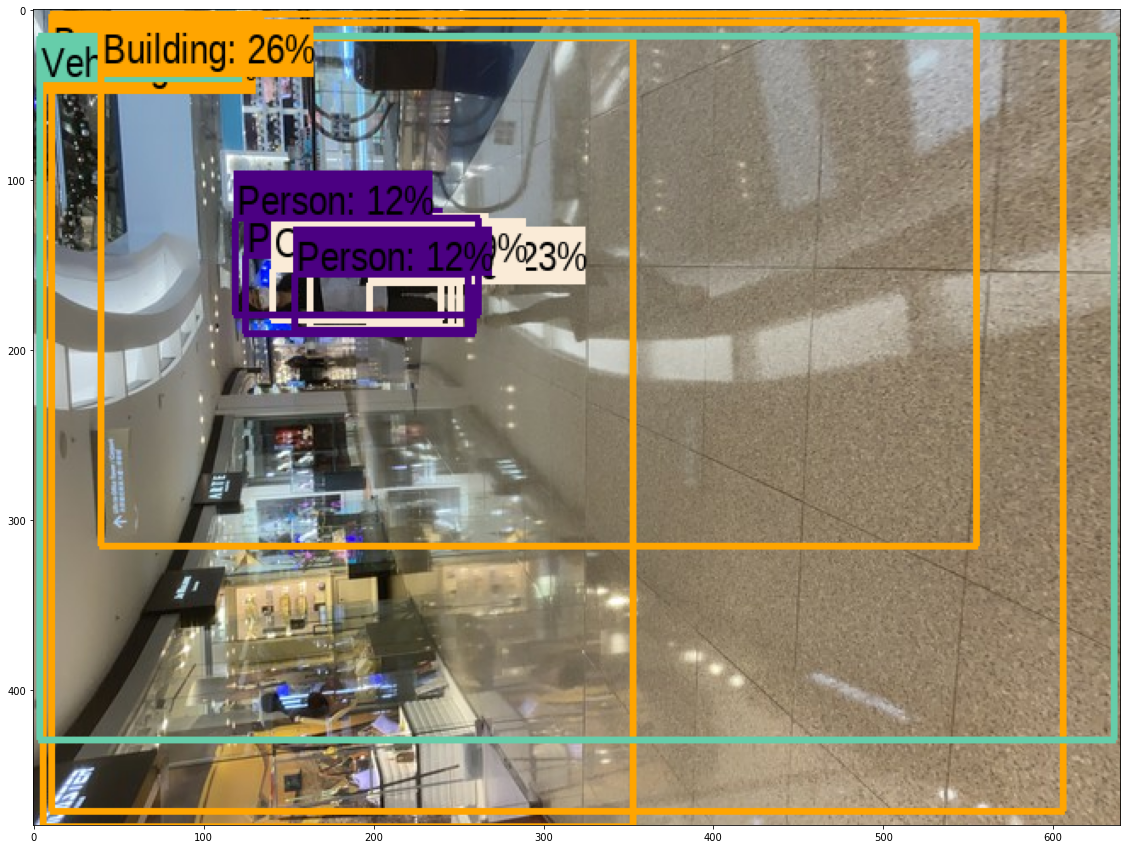

In [ ]:
detect_img(image_urls[0])

If the image do not have any limbs or face, the module may not detect it as a person. 

Image downloaded to /tmp/tmpp0t8dakt.jpg.
Found 100 objects.
Inference time:  24.835928201675415
Inference time: 25.719162940979004


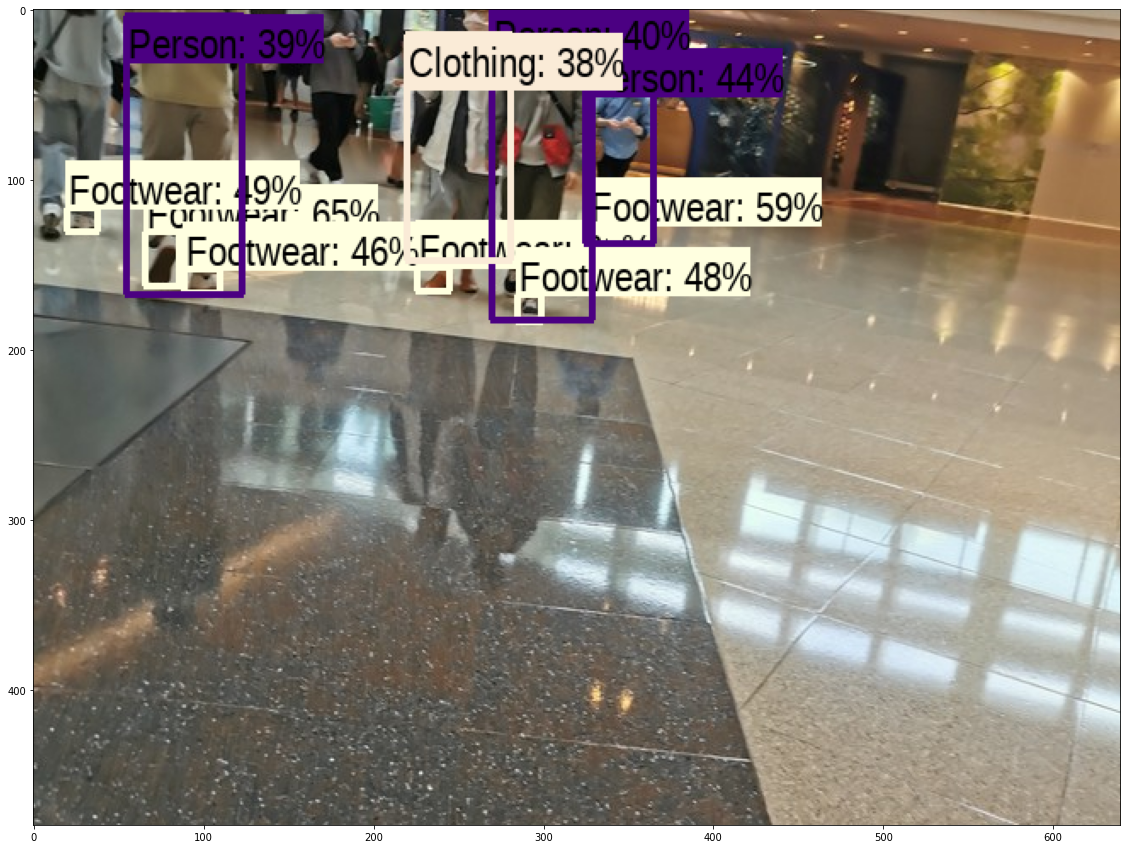

In [ ]:
detect_img(image_urls[1])

Object detection not only detect the person, but also some facilities such as tables and chairs. We can also add the fixed object to our object distance measurement which can help the user to stay away the fixed object.

Image downloaded to /tmp/tmpv8uh45y4.jpg.
Found 100 objects.
Inference time:  24.901017665863037
Inference time: 26.172993659973145


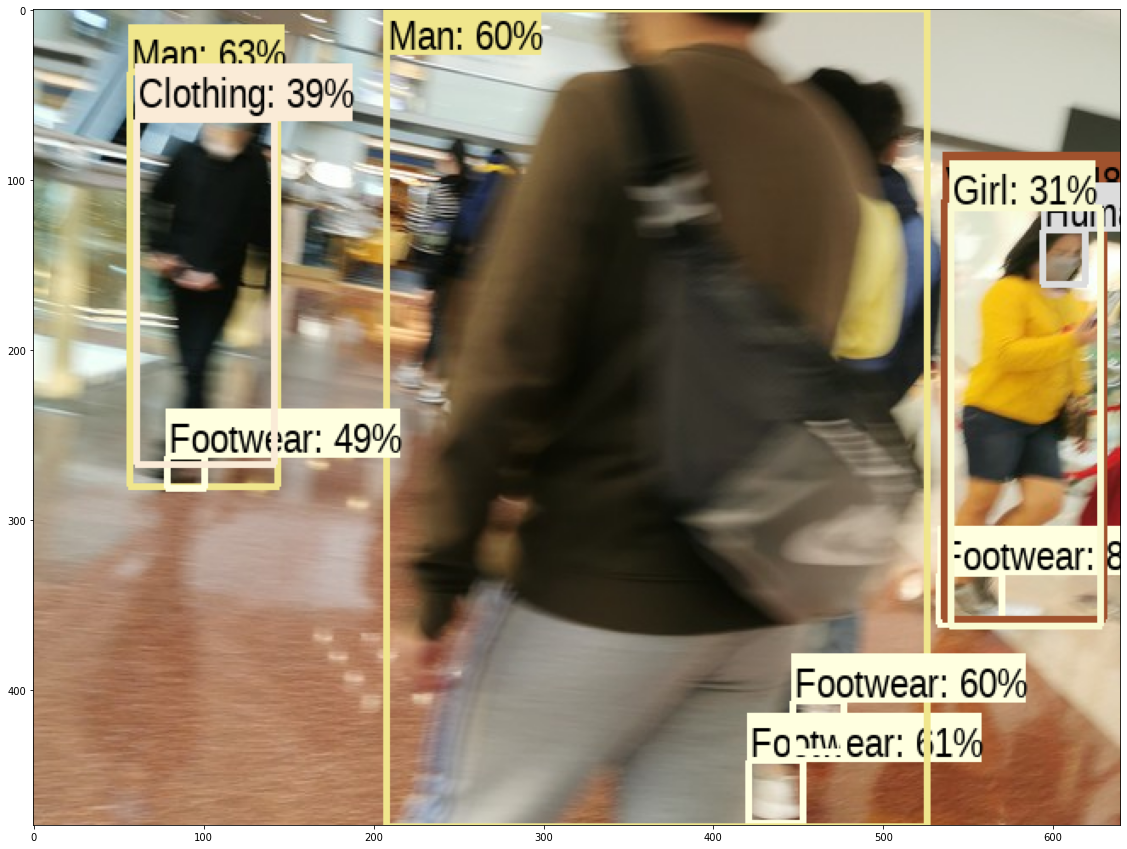

In [ ]:
detect_img(image_urls[2])

The result shows that even the object is moving fast, it still can be detected.

#Measure the object distance
This part is used for measure the distance between the person and camera. We use ultrasonic distance measurement for detection. 

If the distance between the person and camera is too close (e.g, < 15cm),it will be defined as a dangerous distance.

Since we haven't buy the ultrasonic device, this part cannot run the cells to show the result.

The source is from ultrasonic_1.py, author Matt Hawkins.

[Ultrasonic Distance Measurement Using Python](https://www.raspberrypi-spy.co.uk/2012/12/ultrasonic-distance-measurement-using-python-part-1/)


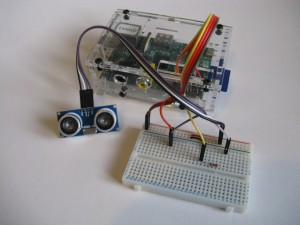

The ultrasonic sensor.

In [ ]:
#!/usr/bin/python
#+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
#|R|a|s|p|b|e|r|r|y|P|i|-|S|p|y|.|c|o|.|u|k|
#+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
#
# ultrasonic_1.py
# Measure distance using an ultrasonic module
#
# Author : Matt Hawkins
# Date   : 09/01/2013 

In [ ]:
# Import required Python libraries
import time
import RPi.GPIO as GPIO

# Use BCM GPIO references
# instead of physical pin numbers
GPIO.setmode(GPIO.BCM)

# Define GPIO to use on Pi
GPIO_TRIGGER = 23
GPIO_ECHO    = 24

print "Ultrasonic Measurement"

# Set pins as output and input
GPIO.setup(GPIO_TRIGGER,GPIO.OUT)  # Trigger
GPIO.setup(GPIO_ECHO,GPIO.IN)      # Echo

# Set trigger to False (Low)
GPIO.output(GPIO_TRIGGER, False)

# Allow module to settle
time.sleep(0.5)

# Send 10us pulse to trigger
GPIO.output(GPIO_TRIGGER, True)
time.sleep(0.00001)
GPIO.output(GPIO_TRIGGER, False)
start = time.time()

while GPIO.input(GPIO_ECHO)==0:
  start = time.time()

while GPIO.input(GPIO_ECHO)==1:
  stop = time.time()

# Calculate pulse length
elapsed = stop-start

# Distance pulse travelled in that time is time
# multiplied by the speed of sound (cm/s)
distance = elapsed * 34300

# That was the distance there and back so halve the value
distance = distance / 2

print "Distance : %.1f" % distance

# Reset GPIO settings
GPIO.cleanup()

In [ ]:
if distance < 15:
  print "There is a danger in front, please be careful."
else:
  print "It is safe."

#Giving Response
We would like to use speaker to remind the user to be careful around the surrounding. 
We will use Google's speech API for text-to-sppech service to provide natural speech.
This part can perform on PYNQ borad.

In [ ]:
from gtts import gTTS

words = "There is a danger in front, please be careful."

tts = gTTS(words)
tts.save("data/ttsdemo.mp3")

In [ ]:
from pydub import AudioSegment

mp3 = AudioSegment.from_mp3("data/ttsdemo.mp3")
mp3.export("data/ttsdemo.wav", format="wav")

In [ ]:
IPAudio("data/ttsdemo.wav")